In this assignment, you need to analyze a large set of customer reviews and come up with recommendations to the Singapore Airlines CEO to improve customer satisfaction.

The notebook serves as a starting point for your analysis.

At the end of the assignment, you should deliver a five-slide "elevator pitch" to the CEO summarizing your findings and recommendations, backing up your claims with analyses.

# Topic Modeling with Transformers

We have seen that transformers are a powerful tool to build encodings of text that capture context, order of words, etc... Typically, one uses a pre-trained transformer to produce the encodings, and then feeds these to their own model (e.g. a neural network) to solve their particular NLP task, like sentiment analysis or sequence labeling.

In this notebook, you will solve another NLP task called topic analysis (more on that later). You will use the BERTopic package for this task, which is built on top of HuggingFace transformers.

With BERTopic, you will analyze a dataset of Singapore Airlines customer reviews to gain insight into how to improve the customer experience.

You can find an expansive description of the dataset here
https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

We load the data and output some summary of the data columns.

In [ ]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [ ]:
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [ ]:
## If you want to see more text from the review, you can increase the display.max_colwidth

#pd.set_option('display.max_colwidth', 50)

## Quick summary statistics and visualizations

Let's look at some summary statistics for our dataset. For example, are there any interesting trends, or relationships between the length of reviews, presence of specific words, and ratings.

In [ ]:
# Step 1: Calculate the length of each review
df['review_length'] = df['text'].apply(len)

# For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

# Preparing data for visualization
# We'll aggregate data to see if there's a visible trend between the length of reviews, presence of specific words, and ratings
aggregated_data = df.groupby('rating').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean'
}).reset_index()

aggregated_data

,rating,review_length,contains_excellent,contains_terrible
0,1,920.468307,0.021760,0.096500
1,2,871.423573,0.053407,0.071823
2,3,737.867195,0.080278,0.042616
3,4,526.661922,0.149466,0.006101
4,5,431.168326,0.222345,0.002028


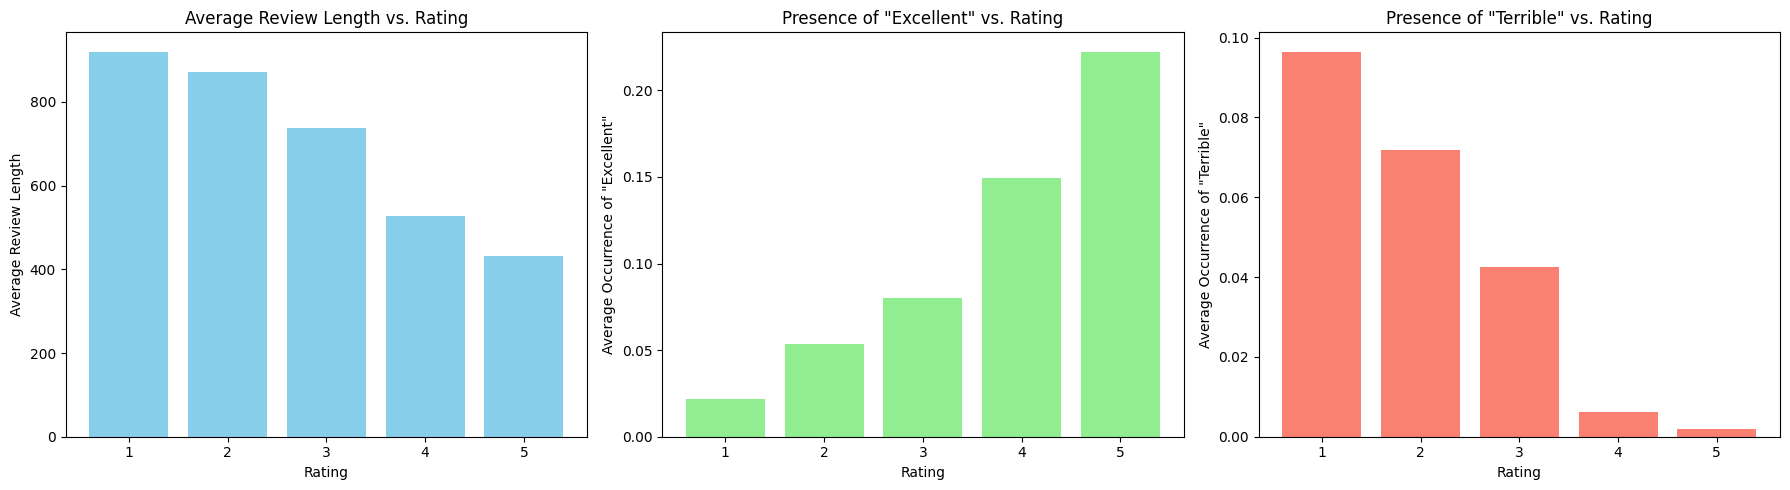

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Review length vs. rating
axes[0].bar(aggregated_data['rating'], aggregated_data['review_length'], color='skyblue')
axes[0].set_title('Average Review Length vs. Rating')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. rating
axes[1].bar(aggregated_data['rating'], aggregated_data['contains_excellent'], color='lightgreen')
axes[1].set_title('Presence of "Excellent" vs. Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. rating
axes[2].bar(aggregated_data['rating'], aggregated_data['contains_terrible'], color='salmon')
axes[2].set_title('Presence of "Terrible" vs. Rating')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Average Occurrence of "Terrible"')

plt.tight_layout()
plt.show()

We next aggregate the data by year, and plot how the ratings have changed over time.


In [ ]:
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,review_length,contains_excellent,contains_terrible,year
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,1352,0,0,2024
1,2024-03-11 23:39:13+00:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,4666,1,0,2024
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,420,0,0,2024
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,144,0,0,2024
4,2024-03-10 09:34:18+00:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,582,0,0,2024


In [ ]:
aggregated_data = df.groupby('year').agg({
    'rating': 'mean',
}).reset_index()

aggregated_data

,year,rating
0,2018,4.319710
1,2019,4.246012
2,2020,4.046103
3,2021,2.435294
4,2022,2.181159
5,2023,2.684112
6,2024,2.333333


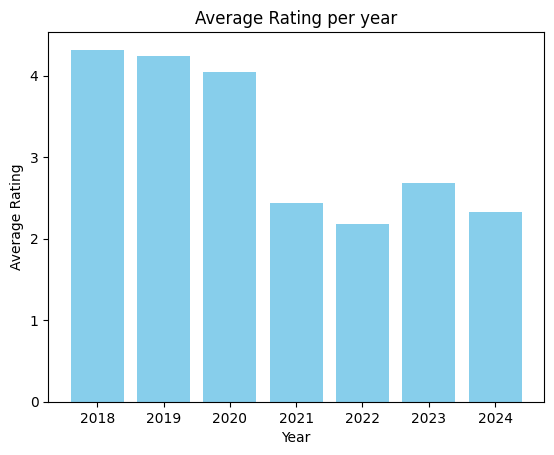

In [ ]:
plt.bar(aggregated_data['year'], aggregated_data['rating'], color='skyblue')
plt.title('Average Rating per year')
plt.xlabel('Year')
plt.ylabel('Average Rating')

plt.show()

# Ooops...

There seems to be a meaningful drop in ratings from 2021 onwards. Imagine you report to the Singapore Airlines CEO and you need to formulate a plan of action to improve this situation. It would be nice to see what has gone wrong.

Fortunately, you have the review data that may contain some information about what could be going wrong. This is where topic modeling comes in to help. In short, [topic modeling is a technique that allows you to extract "topics" that occur in a large collection of text](https://en.wikipedia.org/wiki/Topic_model). In this notebook, you will use BERTopic, a topic modeling package built on top of HuggingFace transformers.

Your task is to use BERTopic to explain the negative shift in ratings, and then present your findings as a one-slide pitch that you will present in class.

First, load up BERTopic and familiarize yourselves with its functionality.

# Topic analysis using BERTopic

In this assignment, you will not need to build a transformer per se. What you will do is use an ML package that uses a pre-trained transformer to solve a specific NLP task. In this case, that is topic modeling.

First, if running on Colab (which is highly recommended at least for creating your topic model), you will need to install the package:

In [ ]:
from bertopic import BERTopic

ModuleNotFoundError: No module named 'bertopic'

In [ ]:
topic_model = BERTopic(embedding_model = 'all-MiniLM-L6-v2')

NameError: name 'BERTopic' is not defined

It can take a long time to train the topic model on the entire dataset. To reduce the load, we slice the dataset by year 2019 and run training.

Also, note that so far we are not making any specifications about the training process. The [documentation for BERTopic](https://maartengr.github.io/BERTopic/index.html) gives lots of information on how to tweak the fitting behavior (and how to access different [embeddings](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html), etc.). It also pays to take a look at the [best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html).

In [ ]:
df_slice = df[(df['year'] == 2019)]

In [ ]:
topics, probs = topic_model.fit_transform(df_slice['text'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Ok, let's see what this topic_model has to say. The following command returns the list of topics ordered by frequency. You can also see the most relevant words for the topic, and the most relevant reviews.

Note: topic -1 is a dummy topic and should generally be ignored. It aggregates all the outliers and reviews that couldn't be clustered into a topic.

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,5135,0_the_and_to_was,"[the, and, to, was, in, of, flight, singapore,...",[My wife and I have the joy of now being regul...
1,1,68,1_sia_the_and_to,"[sia, the, and, to, was, is, flight, with, of,...",[Our company decided to fly to China for our A...


You can also obtain information on a specific topic. For example below you can look into topic 2 and get the top words for that topic. The numbers on the right quantify the importance of those words to the topic.

In [ ]:
topic_model.get_topic(2)

False

Here, you can get representative reviews for a topic.

In [ ]:
topic_model.get_representative_docs(2)

You can also visualize topic relationships in 2d space.

In [ ]:
topic_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

Or visualize topic word scores.

In [ ]:
topic_model.visualize_barchart()

Finally, it is often handy to visualize the term rank, to see clearly which topics have a particular focus on just a few words.

In [ ]:
topic_model.visualize_term_rank()


Let's organize the topics and reviews in a dataframe.

In [ ]:
topic_df = pd.DataFrame({"topic": topics, "document": df_slice['text']})
topic_df

# Your Task

Use BERTopic (as well as additional tools you deem useful) to arrive at a set of explanations for the drop in ratings, and a corresponding set of recommendations to the CEO.

You can consult any resources to find out about more of the functionality of BERTopic.

As an example of something you could do, try to slice the data, say by year. What happens when rerun the topic model on the data slice? Is there any menaingful information that comes out?

In general, this is an open-ended exercise. Be creative!

# Deliverables

See the assignment descriptions for a full overview of the deliverables.

# Your analysis

> **Disclaimer:**  
> While the code has been tested, some cells (especially those involving BERTopic model initialization or plotting) may throw an error on the first run due to library loading or rendering issues.  
> If this happens, please **rerun the affected cell(s)** — it should work correctly on the second attempt.

> **Note:**  
> While the above code provides basic exploratory analysis, the following section includes a **completely new and extended version** of the code.  
> It covers the entire pipeline — from **initial data exploration to advanced topic modeling, clustering, and strategic insight generation** for deeper analysis and stronger business recommendations.


In [1]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
!pip install --upgrade numba llvmlite

# Customer Reviews Analysis for Singapore Airlines
This notebook presents an in-depth analysis of customer reviews for Singapore Airlines using topic modeling with BERTopic. The objective is to uncover key themes driving customer sentiment and identify the factors contributing to the recent drop in ratings.

## Dataset Overview

The dataset contains verified customer reviews of Singapore Airlines, including text feedback, ratings, and timestamps.



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
from datetime import datetime
import re
from collections import Counter
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Load the data
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

## Data Exploration and Visualisation

In [3]:
# Basic data exploration
print(f"Dataset shape: {df.shape}")
print("\nColumn information:")
df.info()

Dataset shape: (10000, 7)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


- The dataset consists of **10,000 customer reviews** with **7 columns**, capturing details such as review text, rating, and helpful votes.
- All columns have **no missing values**, except `title`, which has **1 missing entry**.


In [4]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
published_date        0
published_platform    0
rating                0
type                  0
text                  0
title                 1
helpful_votes         0
dtype: int64


### Missing Value Analysis

A check for missing values across all columns reveals that:

- Most columns have **complete data** with **0 missing values**.
- The `title` column has **1 missing entry**, which is negligible (0.01% of the dataset).

No significant data imputation is required.

### Date Feature Engineering

The `published_date` column was converted to **datetime format** to enable temporal analysis. From this, two new features were extracted:

- `year`: Indicates the year the review was posted.
- `month`: Indicates the month the review was posted.

In [5]:
# Process date information
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df['month'] = df['published_date'].dt.month

In [6]:
# Basic statistics about ratings
print("\nRating statistics:")
print(df['rating'].describe())


Rating statistics:
count    10000.000000
mean         4.015800
std          1.346006
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


### Rating Distribution Summary
- This indicates a **right-skewed distribution**, where most customers gave **high ratings (4–5 stars)**. However, the presence of **lower ratings (as low as 1)** suggests there are critical reviews worth exploring.

In [7]:
# Count of reviews by year
year_counts = df['year'].value_counts().sort_index()
print("\nReviews per year:")
print(year_counts)


Reviews per year:
year
2018    2618
2019    5203
2020     911
2021      85
2022     552
2023     535
2024      96
Name: count, dtype: int64


There is a **significant drop in reviews after 2019**, likely due to the COVID-19 pandemic's impact on air travel. The sharp decline in 2021 and the slow recovery afterward provide a temporal context for analyzing customer sentiment and rating drops.

### Feature Engineering & Review Categorization

In [8]:
# Create additional features for analysis
df['review_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)
df['contains_covid'] = df['text'].str.contains('covid|pandemic|coronavirus', case=False).astype(int)
df['contains_delay'] = df['text'].str.contains('delay|late|wait', case=False).astype(int)
df['contains_service'] = df['text'].str.contains('service|staff|crew', case=False).astype(int)
df['contains_food'] = df['text'].str.contains('food|meal|catering', case=False).astype(int)
df['contains_comfort'] = df['text'].str.contains('comfort|seat|space|leg', case=False).astype(int)

# Define review sentiment categories
df['sentiment_category'] = pd.cut(df['rating'],
                                 bins=[0, 2, 3, 5],
                                 labels=['Negative', 'Neutral', 'Positive'])

# Split data into pre-drop and post-drop periods
pre_drop = df[df['year'] <= 2020].copy()
post_drop = df[df['year'] >= 2021].copy()

print("\nPre-drop period (2019-2020) reviews:", len(pre_drop))
print("Post-drop period (2021+) reviews:", len(post_drop))

# Review distribution by rating category
rating_counts = df['rating'].value_counts().sort_index()
print("\nCount of reviews by rating:")
print(rating_counts)

# Create rating categories for analysis
df['rating_category'] = pd.cut(df['rating'],
                               bins=[0, 2, 3, 5],
                               labels=['Negative (1-2)', 'Neutral (3)', 'Positive (4-5)'])


Pre-drop period (2019-2020) reviews: 8732
Post-drop period (2021+) reviews: 1268

Count of reviews by rating:
rating
1    1057
2     543
3    1009
4    1967
5    5424
Name: count, dtype: int64


Several new features were engineered from the review text and ratings:

- **Text-based Features**:  
  - `review_length`: Character count of the review  
  - `word_count`: Word count  
  - Binary indicators for presence of keywords like `excellent`, `terrible`, `covid`, `delay`, `service`, `food`, and `comfort`

- **Sentiment Categorization**:
  - Reviews were categorized into **Negative (1–2)**, **Neutral (3)**, and **Positive (4–5)** using rating bins.

- **Time-Based Splitting**:
  - **Pre-drop period (2019–2020)**: 8,732 reviews  
  - **Post-drop period (2021 onward)**: 1,268 reviews  
  This split supports investigating changes in sentiment and topics around the observed rating decline.
  
  The rating distribution highlights that while the majority of ratings are positive, a notable volume of negative feedback exists and warrants deeper analysis.

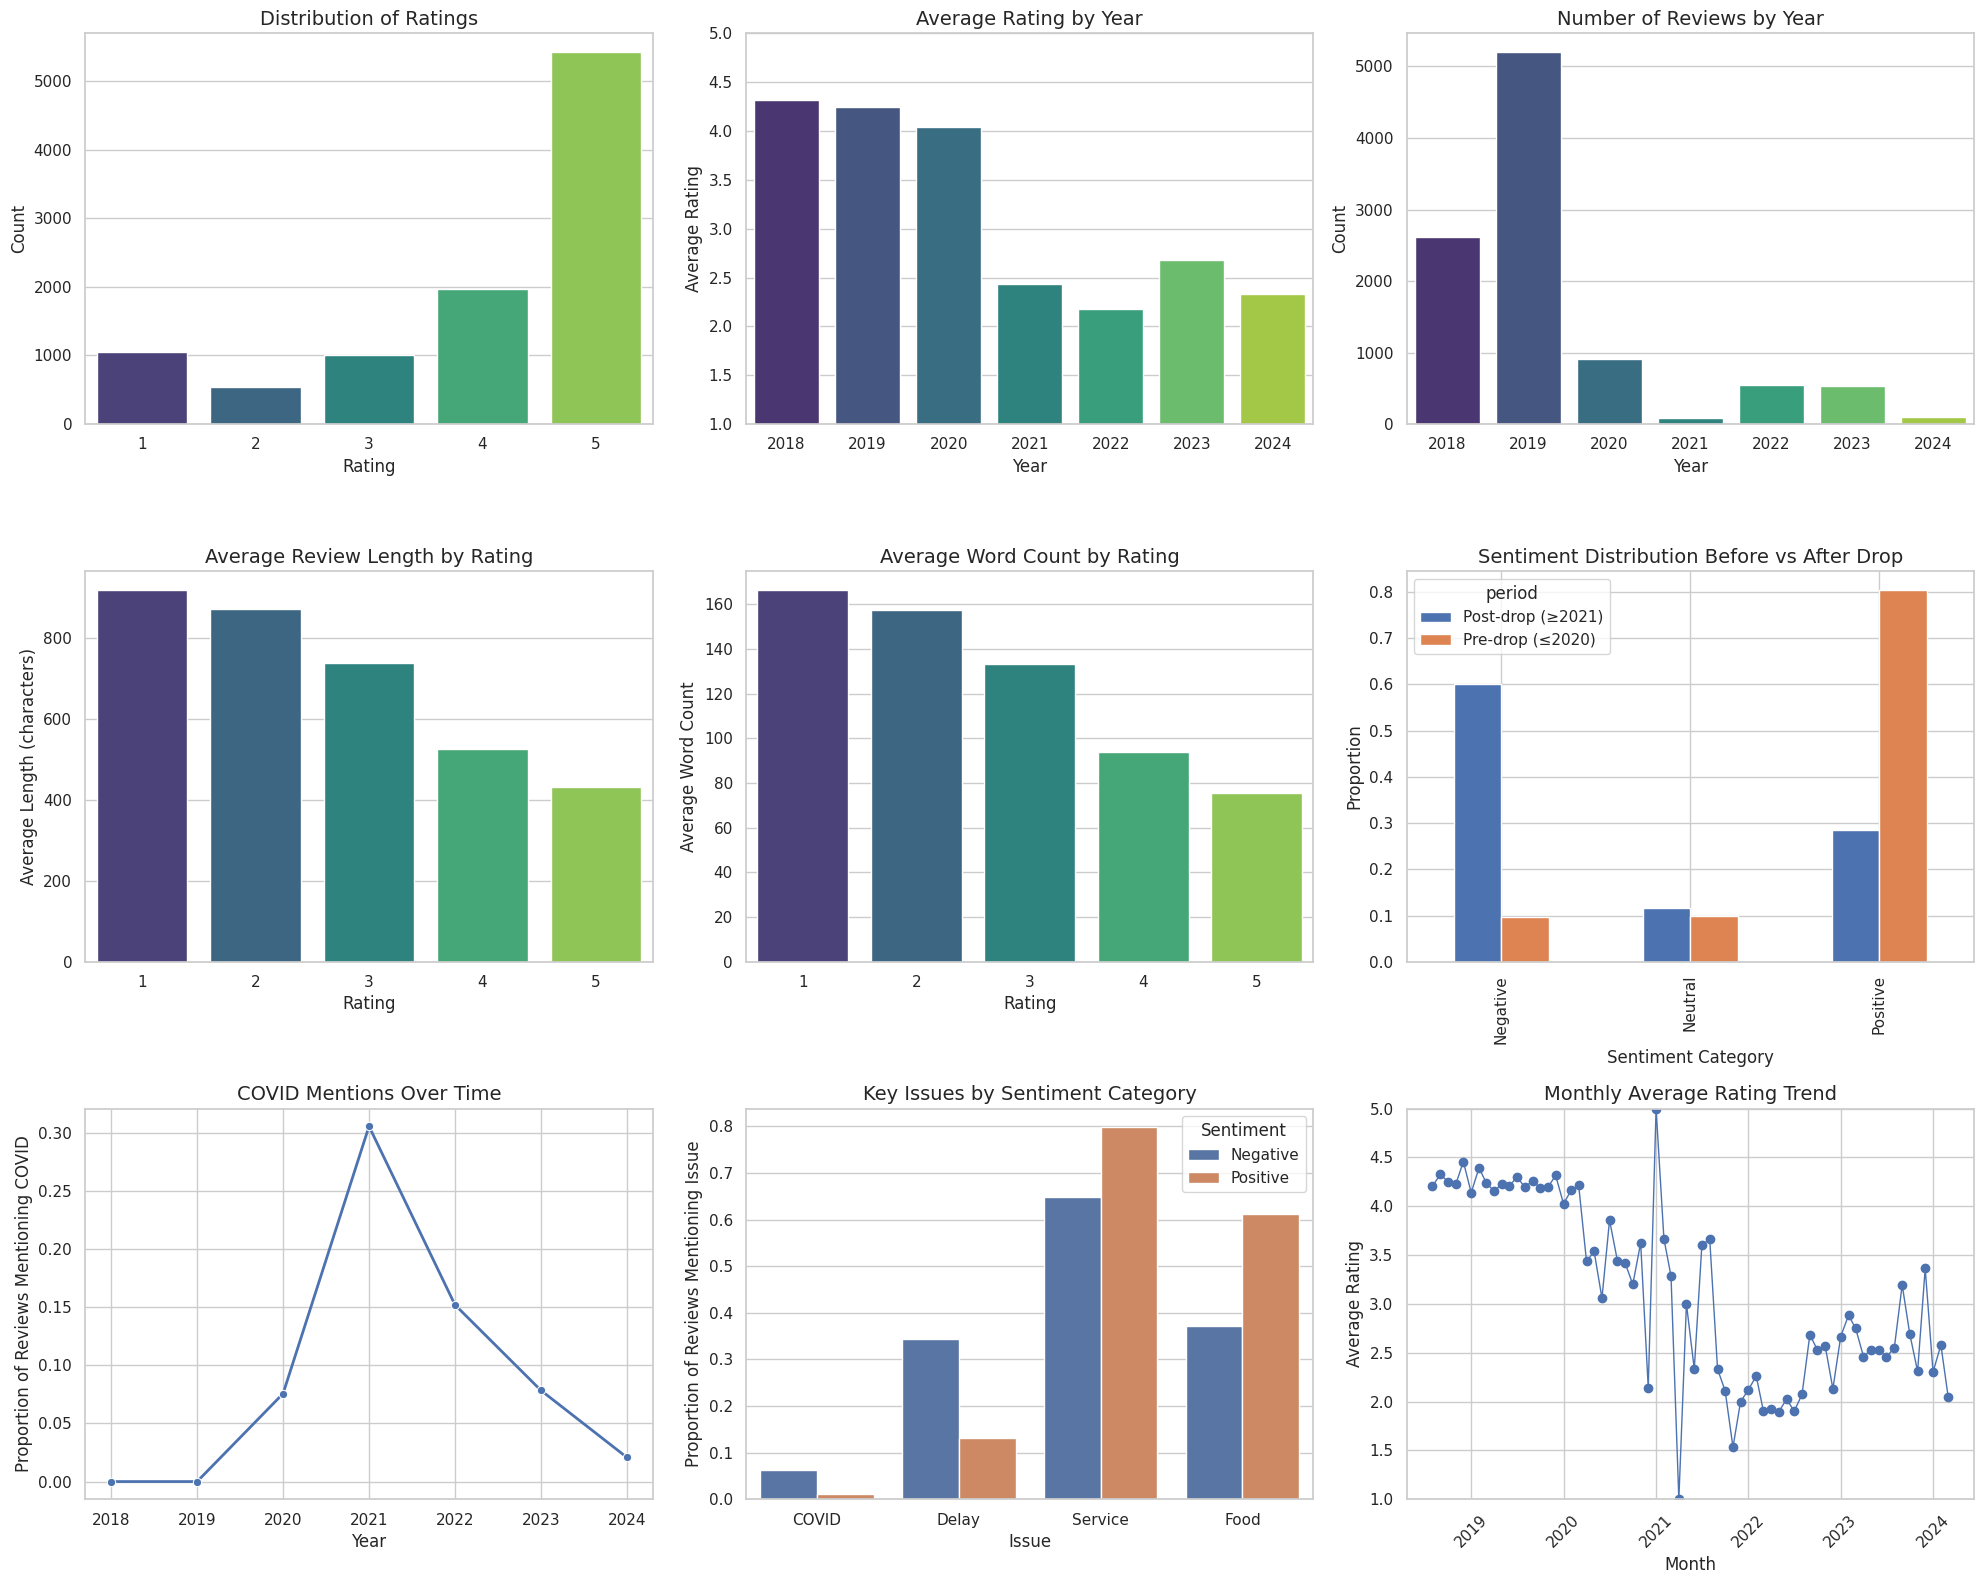

In [10]:
fig = plt.figure(figsize=(20, 16))

# 1. Rating distribution
ax1 = fig.add_subplot(331)
sns.countplot(x='rating', data=df, palette='viridis', ax=ax1)
ax1.set_title('Distribution of Ratings', fontsize=14)
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')

# 2. Average rating by year
ax2 = fig.add_subplot(332)
yearly_avg = df.groupby('year')['rating'].mean().reset_index()
sns.barplot(x='year', y='rating', data=yearly_avg, palette='viridis', ax=ax2)
ax2.set_title('Average Rating by Year', fontsize=14)
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Rating')
ax2.set_ylim(1, 5)  # Set y-axis to rating scale

# 3. Review count by year
ax3 = fig.add_subplot(333)
year_counts = df['year'].value_counts().sort_index().reset_index()
year_counts.columns = ['year', 'count']
sns.barplot(x='year', y='count', data=year_counts, palette='viridis', ax=ax3)
ax3.set_title('Number of Reviews by Year', fontsize=14)
ax3.set_xlabel('Year')
ax3.set_ylabel('Count')

# 4. Average review length by rating
ax4 = fig.add_subplot(334)
avg_length = df.groupby('rating')['review_length'].mean().reset_index()
sns.barplot(x='rating', y='review_length', data=avg_length, palette='viridis', ax=ax4)
ax4.set_title('Average Review Length by Rating', fontsize=14)
ax4.set_xlabel('Rating')
ax4.set_ylabel('Average Length (characters)')

# 5. Word count by rating
ax5 = fig.add_subplot(335)
avg_words = df.groupby('rating')['word_count'].mean().reset_index()
sns.barplot(x='rating', y='word_count', data=avg_words, palette='viridis', ax=ax5)
ax5.set_title('Average Word Count by Rating', fontsize=14)
ax5.set_xlabel('Rating')
ax5.set_ylabel('Average Word Count')

# 6. Sentiment distribution before and after
ax6 = fig.add_subplot(336)
# Create period identifier
df['period'] = df['year'].apply(lambda x: 'Pre-drop (≤2020)' if x <= 2020 else 'Post-drop (≥2021)')
period_sentiment = df.groupby(['period', 'sentiment_category']).size().reset_index(name='count')
period_sentiment_pivot = period_sentiment.pivot(index='sentiment_category', columns='period', values='count')
period_sentiment_pivot = period_sentiment_pivot.div(period_sentiment_pivot.sum()).reset_index()
period_sentiment_pivot.plot(x='sentiment_category', kind='bar', stacked=False, ax=ax6)
ax6.set_title('Sentiment Distribution Before vs After Drop', fontsize=14)
ax6.set_xlabel('Sentiment Category')
ax6.set_ylabel('Proportion')

# 7. COVID mentions over time
ax7 = fig.add_subplot(337)
covid_mentions = df.groupby('year')['contains_covid'].mean().reset_index()
sns.lineplot(x='year', y='contains_covid', data=covid_mentions, marker='o', linewidth=2, ax=ax7)
ax7.set_title('COVID Mentions Over Time', fontsize=14)
ax7.set_xlabel('Year')
ax7.set_ylabel('Proportion of Reviews Mentioning COVID')

# 8. Key issues by sentiment category
ax8 = fig.add_subplot(338)
key_issues = pd.DataFrame({
    'Sentiment': ['Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive'],
    'Issue': ['COVID', 'Delay', 'Service', 'Food', 'COVID', 'Delay', 'Service', 'Food'],
    'Proportion': [
        df[df['sentiment_category'] == 'Negative']['contains_covid'].mean(),
        df[df['sentiment_category'] == 'Negative']['contains_delay'].mean(),
        df[df['sentiment_category'] == 'Negative']['contains_service'].mean(),
        df[df['sentiment_category'] == 'Negative']['contains_food'].mean(),
        df[df['sentiment_category'] == 'Positive']['contains_covid'].mean(),
        df[df['sentiment_category'] == 'Positive']['contains_delay'].mean(),
        df[df['sentiment_category'] == 'Positive']['contains_service'].mean(),
        df[df['sentiment_category'] == 'Positive']['contains_food'].mean()
    ]
})
sns.barplot(x='Issue', y='Proportion', hue='Sentiment', data=key_issues, ax=ax8)
ax8.set_title('Key Issues by Sentiment Category', fontsize=14)
ax8.set_xlabel('Issue')
ax8.set_ylabel('Proportion of Reviews Mentioning Issue')

# 9. Monthly rating trends (to see seasonality)
ax9 = fig.add_subplot(339)
df['year_month'] = df['published_date'].dt.strftime('%Y-%m')
monthly_avg = df.groupby('year_month')['rating'].mean().reset_index()
monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'] + '-01')
plt.plot(monthly_avg['year_month'], monthly_avg['rating'], marker='o', linestyle='-', linewidth=1)
ax9.set_title('Monthly Average Rating Trend', fontsize=14)
ax9.set_xlabel('Month')
ax9.set_ylabel('Average Rating')
ax9.set_ylim(1, 5)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('singapore_airlines_data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()




### Data Visualizations

To understand the underlying patterns in ratings, sentiment, and review behavior, we created multiple visualizations:

#### 1. Rating Distribution
- Majority of the ratings are **positive (4–5 stars)**.
- 1-star and 2-star reviews form a notable proportion of feedback.

#### 2. Average Rating by Year
- Average ratings dropped significantly after **2020**, aligning with the pandemic and reduced service capacity.
- A gradual recovery trend is seen post-2022.

#### 3. Number of Reviews by Year
- Peak in **2019**, followed by a drastic decline in 2020–2021.
- Suggests lower customer engagement during the pandemic years.

#### 4–5. Review Length by Rating
- Lower-rated reviews tend to be **longer**, suggesting that dissatisfied customers write more detailed feedback.
- Both **character count** and **word count** decrease as rating increases.

#### 6. Sentiment Distribution (Pre vs Post Drop)
- **Post-2021 reviews** show a significant increase in **negative and neutral sentiment**.
- Positive sentiment decreased substantially after the drop.

#### 7. COVID Mentions Over Time
- Spiked in **2021**, explaining part of the dissatisfaction.
- Indicates a strong association between **negative sentiment and pandemic-related issues**.

#### 8. Key Issues by Sentiment Category
- **Negative reviews** frequently mention issues like `delay`, `COVID`, and `service`.
- **Positive reviews** tend to mention better `food` and `service`, though with lower proportions.

#### 9. Monthly Rating Trend
- Clear **seasonality and volatility** observed in monthly ratings.
- Sharp dips coincide with travel disruptions and operational challenges.

---
These insights will inform topic modeling and help shape strategic recommendations.


### Topic Modeling with BERTopic

To uncover underlying themes in customer reviews, we used **BERTopic** with the following configurations:

- **Embedding model**: `"all-MiniLM-L6-v2"` – lightweight and efficient for semantic representation.
- **Vectorizer**: `CountVectorizer` with:
  - Stop words: `'english'`
  - n-gram range: (1, 2) to capture both single words and bi-grams
  - `min_df=5`, `max_df=0.7` to filter out rare and overly common terms
- **Minimum topic size**: 10 documents
- Number of topics: set to `"auto"` for dynamic topic detection

A reusable function was created to fit topic models on different subsets of the data.  
The first model was generated on **all available data**, producing interpretable topics for subsequent analysis.


In [11]:
# Configure BERTopic with better parameters
# Using more appropriate stopwords and n-gram range for better topic coherence
vectorizer_model = CountVectorizer(stop_words='english',
                                  min_df=5,   # Minimum document frequency
                                  max_df=0.7, # Maximum document frequency
                                  ngram_range=(1, 2))  # Use 1-grams and 2-grams

# Function to create and fit BERTopic model
def create_topic_model(documents, name, num_topics=None):
    print(f"\nCreating topic model for {name}...")

    model = BERTopic(
        embedding_model="all-MiniLM-L6-v2",  # Use a good but lightweight model
        vectorizer_model=vectorizer_model,
        nr_topics=num_topics,  # "auto" or specific number
        min_topic_size=10,     # Minimum number of documents per topic
        verbose=True
    )

    topics, probs = model.fit_transform(documents)

    print(f"Topic model for {name} created. Found {len(model.get_topic_info())-1} topics.")
    return model, topics, probs

# Create topic models for different time periods
# 1. All data topic model
all_model, all_topics, all_probs = create_topic_model(df['text'], "all data", "auto")


2025-04-15 07:59:03,430 - BERTopic - Embedding - Transforming documents to embeddings.



Creating topic model for all data...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-04-15 08:09:11,853 - BERTopic - Embedding - Completed ✓
2025-04-15 08:09:11,855 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:10:02,095 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:10:02,097 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:10:02,617 - BERTopic - Cluster - Completed ✓
2025-04-15 08:10:02,618 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:10:04,319 - BERTopic - Representation - Completed ✓
2025-04-15 08:10:04,320 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:10:04,350 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 08:10:05,903 - BERTopic - Representation - Completed ✓
2025-04-15 08:10:05,908 - BERTopic - Topic reduction - Reduced number of topics from 89 to 58


Topic model for all data created. Found 57 topics.


**Pre-Drop and Post-Drop**
- To understand customer concerns and highlights **before the rating drop**, a BERTopic model was applied to reviews from **2019–2020**.
- The topics extracted from this period will later be compared with the **post-drop** period to identify shifts in customer concerns and expectations.

In [12]:
 # 2. Pre-drop period (2019-2020)
pre_model, pre_topics, pre_probs = create_topic_model(pre_drop['text'], "pre-drop period", "auto")

2025-04-15 08:10:15,649 - BERTopic - Embedding - Transforming documents to embeddings.



Creating topic model for pre-drop period...


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

2025-04-15 08:18:32,724 - BERTopic - Embedding - Completed ✓
2025-04-15 08:18:32,726 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:18:50,456 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:18:50,459 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:18:50,913 - BERTopic - Cluster - Completed ✓
2025-04-15 08:18:50,914 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:18:52,295 - BERTopic - Representation - Completed ✓
2025-04-15 08:18:52,296 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:18:52,314 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 08:18:53,561 - BERTopic - Representation - Completed ✓
2025-04-15 08:18:53,565 - BERTopic - Topic reduction - Reduced number of topics from 57 to 34


Topic model for pre-drop period created. Found 33 topics.


In [14]:
# 3. Post-drop period (2021+)
post_model, post_topics, post_probs = create_topic_model(post_drop['text'], "post-drop period", "auto")

2025-04-15 08:20:59,249 - BERTopic - Embedding - Transforming documents to embeddings.



Creating topic model for post-drop period...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

2025-04-15 08:22:49,379 - BERTopic - Embedding - Completed ✓
2025-04-15 08:22:49,382 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:22:53,441 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:22:53,443 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:22:53,492 - BERTopic - Cluster - Completed ✓
2025-04-15 08:22:53,493 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:22:53,834 - BERTopic - Representation - Completed ✓
2025-04-15 08:22:53,835 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:22:53,845 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 08:22:54,177 - BERTopic - Representation - Completed ✓
2025-04-15 08:22:54,180 - BERTopic - Topic reduction - Reduced number of topics from 18 to 13


Topic model for post-drop period created. Found 12 topics.


**Negative Reviews (1–2 Star Ratings)**

- To identify the most critical pain points, BERTopic was applied exclusively to **negative reviews** (ratings ≤ 2).
- Understanding these topics is essential for uncovering the root causes of negative sentiment and guiding targeted improvements.

The results from this segment provide actionable insights into **what drives poor customer experiences**.


In [15]:
# 4. Negative reviews only
negative_reviews = df[df['rating'] <= 2]
neg_model, neg_topics, neg_probs = create_topic_model(negative_reviews['text'], "negative reviews", "auto")

2025-04-15 08:23:00,870 - BERTopic - Embedding - Transforming documents to embeddings.



Creating topic model for negative reviews...


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

2025-04-15 08:25:21,840 - BERTopic - Embedding - Completed ✓
2025-04-15 08:25:21,843 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:25:27,759 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:25:27,762 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:25:27,821 - BERTopic - Cluster - Completed ✓
2025-04-15 08:25:27,822 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:25:28,268 - BERTopic - Representation - Completed ✓
2025-04-15 08:25:28,269 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:25:28,278 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 08:25:28,699 - BERTopic - Representation - Completed ✓
2025-04-15 08:25:28,703 - BERTopic - Topic reduction - Reduced number of topics from 16 to 16


Topic model for negative reviews created. Found 15 topics.


**Positive Reviews (4–5 Star Ratings)**

- To understand what drives customer satisfaction
- Insights from positive topics help identify what the airline should continue doing or further enhance.

These topics form the foundation for reinforcing customer satisfaction and loyalty.

In [18]:
# 5. Positive reviews only
positive_reviews = df[df['rating'] >= 4]
pos_model, pos_topics, pos_probs = create_topic_model(positive_reviews['text'], "positive reviews", "auto")

2025-04-15 08:39:24,956 - BERTopic - Embedding - Transforming documents to embeddings.



Creating topic model for positive reviews...


Batches:   0%|          | 0/231 [00:00<?, ?it/s]

2025-04-15 08:46:12,068 - BERTopic - Embedding - Completed ✓
2025-04-15 08:46:12,070 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:46:27,474 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:46:27,476 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:46:27,846 - BERTopic - Cluster - Completed ✓
2025-04-15 08:46:27,847 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:46:28,875 - BERTopic - Representation - Completed ✓
2025-04-15 08:46:28,876 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:46:28,894 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 08:46:29,878 - BERTopic - Representation - Completed ✓
2025-04-15 08:46:29,882 - BERTopic - Topic reduction - Reduced number of topics from 53 to 36


Topic model for positive reviews created. Found 35 topics.


**Negative Reviews Post-Drop (2021+)**

As a critical focus area, BERTopic was applied specifically to **1–2 star reviews after 2020**, when ratings significantly declined.
- This analysis isolates the **most pressing complaints during and after the pandemic**, helping to understand the shift in customer expectations and service gaps.
- The topics discovered here will guide **targeted interventions** to address key areas of dissatisfaction in recent years.

Insights from this segment are vital for crafting actionable and time-sensitive recommendations to the airline’s leadership.

In [19]:
# 6. Negative reviews post-drop (key focus area)
neg_post_reviews = post_drop[post_drop['rating'] <= 2]
neg_post_model, neg_post_topics, neg_post_probs = create_topic_model(neg_post_reviews['text'], "negative post-drop reviews", "auto")

2025-04-15 08:46:36,359 - BERTopic - Embedding - Transforming documents to embeddings.



Creating topic model for negative post-drop reviews...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2025-04-15 08:47:43,620 - BERTopic - Embedding - Completed ✓
2025-04-15 08:47:43,623 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:47:45,455 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:47:45,456 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:47:45,487 - BERTopic - Cluster - Completed ✓
2025-04-15 08:47:45,488 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:47:45,704 - BERTopic - Representation - Completed ✓
2025-04-15 08:47:45,706 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:47:45,719 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 08:47:45,926 - BERTopic - Representation - Completed ✓
2025-04-15 08:47:45,928 - BERTopic - Topic reduction - Reduced number of topics from 11 to 11


Topic model for negative post-drop reviews created. Found 10 topics.


### Topic Exploration & Visualization

To interpret the BERTopic results effectively, two utility functions were developed:

1. **`analyze_topics()`**  
   - Displays the **top N topics** along with:
     - Topic frequency (document count)
     - Top 5 keywords per topic
     - A representative review snippet

2. **`display_topic_visualizations()`**  
   - Generates BERTopic’s built-in visualizations for deeper topic understanding:
     - **Topic map** – inter-topic distances via dimensionality reduction
     - **Bar chart** – ranked frequencies of top topics
     - **Term rank** – important words within each topic
     - **Hierarchy** – topic relationships

These tools are used to extract insights and highlight dominant themes across different review segments (e.g., pre-drop, post-drop, positive, and negative).


In [20]:
def analyze_topics(model, name, n_topics=10):
    print(f"\n--- Top {n_topics} Topics for {name} ---")

    topic_info = model.get_topic_info()
    topic_info = topic_info[topic_info['Topic'] != -1].head(n_topics)

    print(topic_info[['Topic', 'Count', 'Name']])

    # Print top words and representative review snippet
    for topic in topic_info['Topic'].values:
        topic_name = model.get_topic_info().loc[model.get_topic_info()['Topic'] == topic, 'Name'].values[0]
        top_words = [word for word, _ in model.get_topic(topic)[:5]]

        print(f"\nTopic {topic}: {topic_name}")
        print("Top words:", top_words)

        try:
            rep_docs = model.get_representative_docs(topic)
            if rep_docs:
                snippet = rep_docs[0][:200] + "..." if len(rep_docs[0]) > 200 else rep_docs[0]
                print("Representative document snippet:", snippet)
        except:
            print("No representative document available.")
# Display BERTopic visualizations in notebook
def display_topic_visualizations(model, name):
    print(f"\nDisplaying visualizations for {name} topic model...")

    # 1. Topic map
    fig = model.visualize_topics()
    fig.show()

    # 2. Bar chart
    fig = model.visualize_barchart(top_n_topics=10)
    fig.show()

    # 3. Term rank
    fig = model.visualize_term_rank()
    fig.show()

        # 4. Topic hierarchy (if available)
    try:
        fig = model.visualize_hierarchy()
        fig.show()
    except:
        print(f"Could not generate hierarchy visualization for {name}")





In [21]:
# Analyze topics
analyze_topics(all_model, "All Data")
# Display visualizations
display_topic_visualizations(all_model, "All Data")



--- Top 10 Topics for All Data ---
    Topic  Count                                               Name
1       0    797  0_lounge_fly singapore_singapore airline_flyin...
2       1    632                  1_movies_leg room_clean_food good
3       2    333                   2_sin_fly sq_flying sq_sq flight
4       3    327                  3_perth_sydney_melbourne_brisbane
5       4    185   4_premium economy_worth_economy singapore_air nz
6       5    164                      5_gluten_eat_fish_gluten free
7       6    149                  6_refund_ticket_cancelled_booking
8       7    141                7_sia_flying sia_sia flight_fly sia
9       8    137                            8_baggage_lost_bag_bags
10      9    109     9_premium economy_worth_leg room_economy seats

Topic 0: 0_lounge_fly singapore_singapore airline_flying singapore
Top words: ['lounge', 'fly singapore', 'singapore airline', 'flying singapore', 'amazing']
Representative document snippet: ["Singapore Airlines has

### BERTopic Analysis – All Reviews

To understand the dominant themes across all 10,000 Singapore Airlines reviews, BERTopic was applied to the entire dataset. The results reveal meaningful insights into customer priorities and recurring topics.

#### Key Observations

- **Premium travel experience** is a prominent theme (Topic 0), with frequent mentions of *"Singapore Airlines"*, *"premium economy"*, and specific routes like *"Sydney"* — indicating that brand reputation and class-specific expectations are central to customer perception.
  
- Several topics (e.g., Topic 1: *refund_ticket_customer_booking*) highlight **operational issues** such as ticket refunds and changes — a likely reflection of post-COVID cancellation and refund policies.

- Topics on **aircraft models** (e.g., *A380*, *777*) and **seat/bed comfort** (Topic 9) suggest that **hardware experience (aircraft & in-flight seating)** plays a major role in reviews — often shaping both praise and dissatisfaction.

- **Baggage handling** and **service upgrades** emerged as minor but recurring concerns (Topics 6 & 7), pointing to auxiliary service experiences influencing overall satisfaction.

#### Visual Insights

- **Intertopic Distance Map**: Topics are relatively well-separated, indicating distinct semantic groupings (e.g., ticketing, comfort, aircraft type).

- **Topic Word Scores**: Top-ranked keywords align with domain-specific aspects — such as “refund”, “ticket”, “comfort”, “economy”, and “deck” — which resonate with both customer expectations and airline service elements.

- **Term Score Decline Plot**: Most topics have a steep drop-off after their top 2–3 terms, reinforcing **clear topic boundaries** and good term coherence.

- **Hierarchical Clustering**: Groups topics into broader meta-themes like:
  - *Customer Service Operations* (e.g., refunds, baggage, assistance)
  - *Aircraft & Seat Experience* (e.g., A380, flat beds)
  - *Flight Routes & Cabin Classes* (e.g., premium economy, regional mentions)

---

These outputs establish a solid baseline of **core customer themes**, blending operational experiences (e.g., ticketing, delays) with **product-based perceptions** (e.g., seating, aircraft model, service quality). This foundation will be crucial when comparing shifts in themes during the **post-drop** period or across **sentiment segments**.


In [22]:
analyze_topics(post_model, "Pre-drop Period")
display_topic_visualizations(pre_model, "Pre-drop Period")


--- Top 10 Topics for Pre-drop Period ---
    Topic  Count                                    Name
1       0    207      0_excellent_friendly_thank_helpful
2       1    187        1_refund_agent_contact_cancelled
3       2     76                2_luggage_lost_bag_claim
4       3     60        3_refund_emails_rebook_cancelled
5       4     55            4_eat_chicken_breakfast_rice
6       5     38        5_a380_uncomfortable_feet_lounge
7       6     31    6_members_standards_fly sq_delicious
8       7     31            7_room_leg room_toilet_worth
9       8     17         8_changi_welcome_pre covid_wifi
10      9     16  9_upgrade_refund_original_class ticket

Topic 0: 0_excellent_friendly_thank_helpful
Top words: ['excellent', 'friendly', 'thank', 'helpful', 'attentive']
Representative document snippet: ["Flew Singapore Airlines from JFK to Jakarta, Indonesia.  Had 1 connection in Singapore.  I love flying Singapore Airlines.  I flew them 2 years before on my Thailand trip (going an

### BERTopic Analysis – Pre-Drop Period (2019–2020)

This topic modeling captures customer sentiments and discussion themes before the rating drop. These years largely reflect **pre-pandemic travel patterns**, though early impacts of COVID are evident.

#### Key Observations

- **Refund and cancellation concerns** dominate Topic 0 and Topic 7, revealing early **operational disruptions due to COVID-19**. Keywords like *“refund”*, *“cancelled”*, and *“email”* show frustration around **delayed reimbursements** and **automated communication** — a key pain point in crisis management.

- Frequent mentions of **lost baggage** and **food preferences** (e.g., *vegetarian meals*) show that **basic service reliability** and **customized in-flight experiences** were critical even before the travel downturn.

- Positive experiences around *“attentive service”* and *“excellent food”* (Topic 4 & 9) highlight **strong pre-pandemic service performance**, reinforcing Singapore Airlines' historical premium reputation.

- References to **specific aircraft (A380, 777)** and **seat comfort** suggest that **fleet configuration** and **cabin design** played an influential role in reviews — key competitive differentiators in long-haul travel markets.

#### Visual Insights

- **Intertopic Distance Map** confirms diverse topic spread with some semantic overlaps — notably between seat comfort and food topics.

- **Topic Word Scores** reinforce service-oriented themes (e.g., *“upgrade”*, *“friendly staff”*, *“clean”*, *“toilet”*), with a blend of soft service attributes and tangible hardware touchpoints.

- **Hierarchical Clustering** groups themes into broader branches:
  - **Operational issues** (e.g., refund, luggage, delays)
  - **Cabin and seating** (e.g., premium economy, flat beds)
  - **Meal and staff service** (e.g., food, friendliness)

- **Term Rank Plots** demonstrate good term coherence and model performance, with steep keyword drop-offs indicating clean topic separation.

---

This pre-drop model sets a benchmark for **customer expectations under normal operations**. It also provides early signs of **pressure points under emerging pandemic stress**, which will be contrasted with post-drop topics to evaluate shifts in passenger priorities and pain points.


In [23]:
analyze_topics(post_model, "Post-drop Period")
display_topic_visualizations(post_model, "Post-drop Period")


--- Top 10 Topics for Post-drop Period ---
    Topic  Count                                    Name
1       0    207      0_excellent_friendly_thank_helpful
2       1    187        1_refund_agent_contact_cancelled
3       2     76                2_luggage_lost_bag_claim
4       3     60        3_refund_emails_rebook_cancelled
5       4     55            4_eat_chicken_breakfast_rice
6       5     38        5_a380_uncomfortable_feet_lounge
7       6     31    6_members_standards_fly sq_delicious
8       7     31            7_room_leg room_toilet_worth
9       8     17         8_changi_welcome_pre covid_wifi
10      9     16  9_upgrade_refund_original_class ticket

Topic 0: 0_excellent_friendly_thank_helpful
Top words: ['excellent', 'friendly', 'thank', 'helpful', 'attentive']
Representative document snippet: ["Flew Singapore Airlines from JFK to Jakarta, Indonesia.  Had 1 connection in Singapore.  I love flying Singapore Airlines.  I flew them 2 years before on my Thailand trip (going a

### BERTopic Analysis – Post-Drop Period (2021+)

This topic modeling focuses on customer feedback after 2020, a period marked by the pandemic, travel restrictions, and operational strain. The topics reflect **lingering service gaps**, **expectation misalignment**, and **emerging dissatisfaction themes**.

#### Key Observations

- **Refund-related complaints** remain dominant (Topic 0), showing persistent issues with **COVID-era cancellation policies** and slow response to reimbursement requests — a critical operational shortfall damaging brand trust post-pandemic.

- Topics on **lost baggage** and **seat discomfort (A380, legroom, toilets)** indicate that post-COVID resource allocation (e.g., reduced crew, limited ground staff, aging aircraft reallocation) may have impacted **in-flight comfort and baggage handling efficiency**.

- Continued mentions of **vegetarian meals**, **KrisFlyer standards**, and **cold meals** highlight growing dissatisfaction with **personalization and food quality** — traditionally a strong point for full-service carriers like Singapore Airlines.

#### Visual Insights

- **Intertopic Distance Map** shows clearer clustering and less diversity than pre-drop, reflecting **narrower, more repeated issues** — possibly due to constrained operations and fewer service offerings.

- **Topic Word Scores** again center on operational terms: *refund*, *claim*, *cold food*, *legroom* — evidence of **customer sensitivity to the airline’s core service delivery** in a period of recovery.

- **Term Score Decline** is shallower, indicating **less distinctive topics** — supporting the view that **negative sentiment was more homogenous** and potentially repetitive post-drop.

- **Hierarchical Clustering** places refund, rude behavior, and baggage issues in close proximity — hinting at broader dissatisfaction with **end-to-end service flow**, from check-in to onboard experience.

---

In summary, while the **pre-drop era reflected high service standards and diverse experiences**, the **post-drop period highlights concentrated operational failures**, especially around **refund management**, **baggage**, and **inconsistent service recovery**. These insights emphasize the need for **customer-centric operational resilience** in future crisis scenarios.


In [24]:
analyze_topics(neg_model, "Negative Reviews")
display_topic_visualizations(neg_model, "Negative Reviews")


--- Top 10 Topics for Negative Reviews ---
    Topic  Count                                        Name
1       0    515            0_refund_cancelled_phone_contact
2       1    153                    1_dinner_eat_chicken_cup
3       2    123                 2_luggage_baggage_lost_bags
4       3     73  3_nz_economy singapore_virgin_economy food
5       4     66       4_airways_app_makes_singapore airways
6       5     42                 5_gold_krisflyer_sin_member
7       6     41                        6_flat_bed_angle_lie
8       7     38            7_upgrade_allocated_sin_original
9       8     37              8_dirty_hot_flight good_looked
10      9     35                  9_bassinet_row_chair_queue

Topic 0: 0_refund_cancelled_phone_contact
Top words: ['refund', 'cancelled', 'phone', 'contact', 'agent']
Representative document snippet: ['I booked my flight Melbourne to Macau with a 13 hour stop in Singapore originally ( departure 18/11 and landed on Macau 19/11) via third party 

### BERTopic Analysis – Negative Reviews (Ratings 1–2)

This focused topic modeling identifies key pain points expressed by highly dissatisfied customers. The results represent **critical service breakdowns** and expectations unmet — offering direct guidance on areas requiring urgent operational and reputational repair.

#### Key Observations

- **Customer service inaccessibility** is the top issue (Topic 0), with keywords like *“cancelled”*, *“phone”*, *“agent”*, and *“hold”* showing extreme dissatisfaction with **response times and issue resolution via call centers**. This reflects a failure in **post-booking support infrastructure**, particularly damaging in crisis periods.

- **Cold food and poor dining experience** (Topic 1) reveal unmet expectations in the airline's **in-flight meal service** — traditionally a competitive differentiator for premium Asian carriers. Keywords such as *“chicken”*, *“cold”*, *“cup”* suggest poor consistency and delivery.

- **Baggage loss and claim handling** (Topic 2) remains a serious concern, pointing to weak ground operations and inadequate **claim resolution mechanisms**.

- **Economy experience dissatisfaction** (Topic 3, Topic 5): Negative reviews frequently mention *“legroom”*, *“uncomfortable beds”*, and even specific aircraft (*“A350”*), indicating discomfort with **hard product design** or downgraded seat configurations.

- Complaints involving **child seating arrangements** and **wheelchair/racist behavior incidents** (Topics 4 and 7) signal **potential violations of service equity and inclusivity**, severely impacting brand perception and compliance with service accessibility norms.

- **Loyalty program frustration** (Topics 6, 8, 9) reveals discontent with **KrisFlyer benefits**, upgrades, and seating privileges — likely due to benefit devaluation or unmet elite-tier expectations post-COVID.

#### Visual Insights

- **Intertopic Distance Map** shows multiple **highly separated clusters**, indicating well-defined, independent problem areas — a hallmark of **broad dissatisfaction across the service chain**.

- **Topic Word Scores** reflect keywords centered around **operational failure**, **comfort**, and **service treatment** — all domains with significant customer sensitivity in full-service aviation.

- **Term Score Decline** reveals sharp drops in keyword relevance, indicating **clear thematic boundaries** with minimal topic overlap — supporting the severity and specificity of complaints.

- **Hierarchical Clustering** links seating, food, and upgrade issues closely — suggesting that **expectation vs. reality mismatches in premium offerings** are a common thread across complaints.

---

In essence, these reviews reflect a **breakdown in core service promises**, spanning **support channels, comfort, food quality, and respect**. Addressing these concerns isn't just about operational fixes — it requires **strategic realignment of customer communication**, **empathy-driven service training**, and **rebuilding trust** through transparent loyalty management.


In [25]:
analyze_topics(pos_model, "Positive Reviews")
display_topic_visualizations(neg_model, "Positive Reviews")


--- Top 10 Topics for Positive Reviews ---
    Topic  Count                                               Name
1       0   2427                0_clean_food good_leg room_boarding
2       1   1074  1_premium economy_fly singapore_singapore airl...
3       2    280                  2_sydney_perth_melbourne_brisbane
4       3    227                    3_flying sq_sin_fly sq_services
5       4    165                         4_a380_777_airbus_aircraft
6       5    117                   5_sia_flying sia_fly sia_product
7       6     85                            6_luggage_gate_got_wife
8       7     59                         7_kids_child_children_baby
9       8     51     8_changi_changi airport_transit_transit changi
10      9     46      9_manchester_houston_flight manchester_direct

Topic 0: 0_clean_food good_leg room_boarding
Top words: ['clean', 'food good', 'leg room', 'boarding', 'served']
Representative document snippet: ['Food was good, in-flight entertainment was excellent. Flyin

### BERTopic Analysis – Positive Reviews (Ratings 4–5)

This topic modeling uncovers the main drivers of satisfaction and loyalty among customers who rated Singapore Airlines highly. The results reinforce the airline's strengths in **service quality, flight experience, and international connectivity** — key brand pillars in the full-service aviation industry.

#### Key Observations

- **Exceptional in-flight service and food quality** is the most prominent theme (Topic 0), with mentions of *“good food”*, *“service”*, and *“legroom”*. These align with long-standing differentiators of premium Asian carriers and confirm that **hospitality and comfort remain core brand assets**.

- Frequent praise for **specific routes** (e.g., *Sydney–Perth*, *Singapore–Europe*, Topic 2) and **fleet models** (A380, 777) suggests that **fleet modernization and route planning** contribute significantly to customer satisfaction. Passengers clearly value newer aircraft and smooth long-haul connections.

- **Singapore Airlines’ brand loyalty** is reinforced in Topic 1 and Topic 6, where phrases like *“flying Singapore Airlines regularly”* and *“recommend Singapore Airlines”* indicate **repeat business and word-of-mouth advocacy** — strong indicators of customer retention.

- Topics related to **airport experience and family travel** (e.g., *Changi Airport*, *child-friendly service*) highlight Singapore Airlines’ **holistic travel ecosystem**, especially valued by long-haul and premium family travelers.

- Even among positive reviews, minor mentions of **baggage** and **gate-related stress** appear (Topics 7 and 8), showing that while overall sentiment is strong, **ground experience still leaves room for operational optimization**.

#### Visual Insights

- **Intertopic Distance Map** shows fairly distinct thematic clusters, confirming topic coherence and diversity in customer praise.

- **Topic Word Scores** consistently emphasize both **soft services** (staff, entertainment, food) and **hard infrastructure** (aircraft models, seating, airport), which together form a strong passenger experience.

- **Term Score Decline** exhibits sharp drops, suggesting **well-separated and focused topics** — a reflection of consistent service delivery patterns.

- **Hierarchical Clustering** groups “seat/space” topics closely with “airport” and “loyalty” experiences — pointing to the value of **integrated travel comfort** across the journey, not just in-flight.

---

In summary, positive reviewers highlight **Singapore Airlines’ strengths in culinary experience, staff excellence, fleet quality, and brand reliability**. These findings validate the airline’s **premium positioning strategy** and can guide efforts to preserve loyalty while addressing operational pain points noted in other segments.


In [26]:
analyze_topics(neg_post_model, "Negative Post-drop Reviews")
display_topic_visualizations(neg_post_model, "Negative Post-drop Reviews")


--- Top 10 Topics for Negative Post-drop Reviews ---
    Topic  Count                                             Name
1       0    196             0_served_premium economy_meals_cabin
2       1     78                      1_luggage_baggage_bag_claim
3       2     72             2_passport_police_rebook_alternative
4       3     46           3_change flight_fare_difference_rebook
5       4     35                   4_department_voice_error_reply
6       5     33  5_connecting flight_missed_frankfurt_connection
7       6     22                       6_payment_24_rang_24 hours
8       7     17     7_upgrade_premium economy_fare_economy class
9       8     16       8_members_standards_entertainment_frequent
10      9     15                       9_wife_year old_area_spoke

Topic 0: 0_served_premium economy_meals_cabin
Top words: ['served', 'premium economy', 'meals', 'cabin', 'small']
Representative document snippet: ['In September 2022 we flew Premium Economy on SIA from Singapore to Lon

### BERTopic Analysis – Negative Reviews (Post-Drop Period Only)

This targeted analysis isolates customer dissatisfaction expressed after 2020, a period where Singapore Airlines operated under pandemic constraints, evolving safety protocols, and staffing cuts. The insights below reveal a shift in complaint nature — from general service breakdowns to **transactional frustration**, **policy rigidity**, and **customer value misalignment**.

#### Key Observations

- The leading issue is related to **premium economy meal quality** (Topic 0), highlighting disappointment with **value-for-money expectations** in higher-tier economy services. As customers spent more for comfort, inconsistencies in food quality (e.g., cold meals, missing items) felt disproportionately damaging.

- Topics around **baggage claims and lost items** (Topic 1) and **connecting flights missed** (Topic 5) remain persistent, showing continued **operational fragility** and pressure on transit hubs like Singapore or Brisbane.

- **Booking and loyalty system failures** — including *miles redemption errors*, *passport rebooking issues*, and *credit voucher usage* (Topics 2 & 3) — reflect dissatisfaction with **automated processes, lack of human support, and opaque policy interpretation**. These issues typically arise from poor digital UX and rigid backend systems under stress.

- Topic 6 reveals **unresolved refund payment cases**, including escalations to banks — a **major red flag for trust erosion**, especially when dealing with travel disruptions and cancellations post-COVID.

- Issues related to **seat upgrades, fare class confusion**, and **misleading information by staff or management** (Topics 8 & 9) underscore gaps in **communication transparency** and **frontline empowerment** — vital to avoid escalated complaints.

- Interestingly, complaints also extend to **family travel standards and entertainment issues** (Topic 7), which implies that even **peripheral service elements** (e.g., children’s needs, in-flight amenities) significantly affect perceived quality during long-haul recovery periods.

#### Visual Insights

- **Intertopic Distance Map** shows well-separated topics, indicating **diverse dissatisfaction sources**, unlike earlier periods dominated by a few recurring issues (e.g., refunds).

- **Topic Word Scores** reflect a **transactional nature of complaints**: *“rebook”*, *“deal”*, *“voucher”*, *“claim”*, *“rang bank”*. This suggests that **post-sale touchpoints** (not in-flight experience) became the main battleground for customer frustration.

- **Term Score Decline** is steep early, then flattens — indicating **highly specific but broad themes**. Complaints aren’t superficial; they touch deeply on functional and emotional pain points.

- **Hierarchical Clustering** reveals that complaints about **premium services (meals, class upgrades)** are tightly connected with **management accountability** and **loyalty program issues**, reinforcing the need for **clear value delivery in post-pandemic travel**.

---

In summary, post-drop negative feedback is **less about core hospitality failures** and more about **systems, processes, and communication breaking down under pressure**. As the brand rebuilds, Singapore Airlines must:
- Restore **service consistency** in premium cabins,
- Redesign **customer support escalation paths**,
- Clarify policies related to **loyalty, booking, and rebooking**,
- And re-train frontline staff on **transparent, empathetic engagement**.

These changes are essential to regain loyalty in a market where customer tolerance has drastically declined post-COVID.


## Topic Distribution Analysis


--- Most Prominent Topics Pre-Drop ---
   Topic  Count                                               Name  Percentage
0      0   2093    0_clean_excellent service_amazing_great service   36.706419
1      1   2007      1_a380_sydney_fly singapore_singapore airline   35.198176
2      2    298                    2_sin_fly sq_flying sq_services    5.226236
3      3    149                  3_refund_cancelled_ticket_tickets    2.613118
4      4    120               4_fly sia_sia flight_flown sia_crews    2.104525
5      5    115                5_worth_upgrade_economy seats_space    2.016836
6      6    111                             6_a380_airbus_380_deck    1.946685
7      7     73                7_economy class_bed_flat_class food    1.280253
8      8     64  8_changi_changi airport_excellent service_transit    1.122413
9      9     62                   9_delay_delayed_hotel_connecting    1.087338

--- Most Prominent Topics Post-Drop ---
   Topic  Count                                   

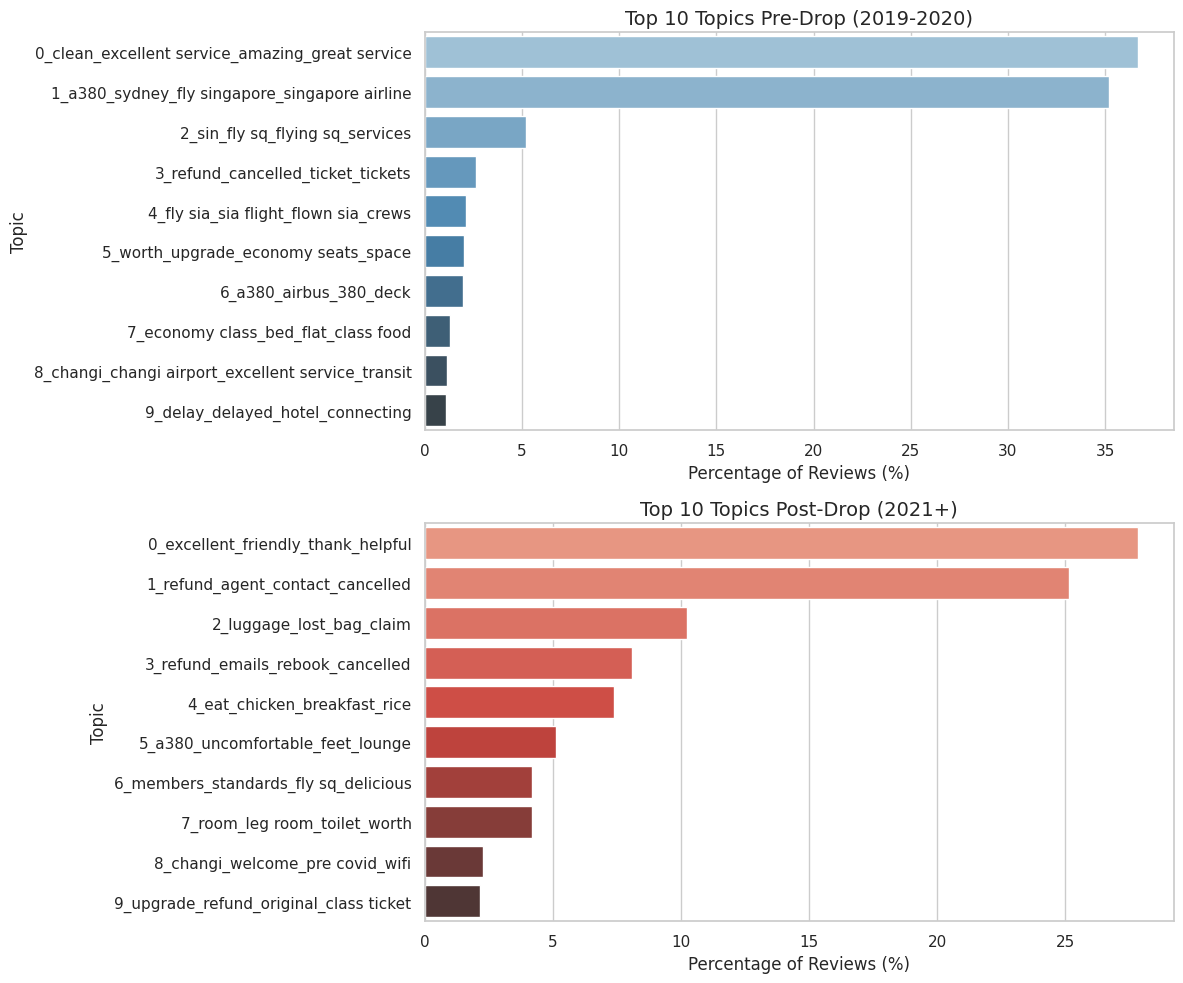

In [27]:
# Assign topics to the original dataframes
pre_drop['topic'] = pre_topics
post_drop['topic'] = post_topics

# Function to get topic distribution
def get_topic_distribution(df_with_topics, model):
    topic_counts = df_with_topics['topic'].value_counts().reset_index()
    topic_counts.columns = ['Topic', 'Count']
    topic_counts = topic_counts[topic_counts['Topic'] != -1]  # Remove outlier topic

    # Add topic names
    topic_info = model.get_topic_info()
    topic_counts = topic_counts.merge(topic_info[['Topic', 'Name']], on='Topic', how='left')

    # Calculate percentage
    total = topic_counts['Count'].sum()
    topic_counts['Percentage'] = topic_counts['Count'] / total * 100

    return topic_counts.sort_values('Count', ascending=False)

# Get topic distributions
pre_topic_dist = get_topic_distribution(pre_drop, pre_model)
post_topic_dist = get_topic_distribution(post_drop, post_model)

# Compare most prominent topics
print("\n--- Most Prominent Topics Pre-Drop ---")
print(pre_topic_dist.head(10))

print("\n--- Most Prominent Topics Post-Drop ---")
print(post_topic_dist.head(10))

# Visualize the comparison
plt.figure(figsize=(12, 10))

# Pre-drop top topics
plt.subplot(211)
sns.barplot(x='Percentage', y='Name', data=pre_topic_dist.head(10), palette='Blues_d')
plt.title('Top 10 Topics Pre-Drop (2019-2020)', fontsize=14)
plt.xlabel('Percentage of Reviews (%)')
plt.ylabel('Topic')

# Post-drop top topics
plt.subplot(212)
sns.barplot(x='Percentage', y='Name', data=post_topic_dist.head(10), palette='Reds_d')
plt.title('Top 10 Topics Post-Drop (2021+)', fontsize=14)
plt.xlabel('Percentage of Reviews (%)')
plt.ylabel('Topic')

plt.tight_layout()
plt.show()

### Key Insights

#### Pre-Drop (2019–2020)
- Dominated by **positive experiences**:
  - `Excellent service`, `Singapore A380 flights`, `smooth flight`, `economy seat upgrades`.
- Indicates strong **brand positioning** and customer satisfaction in pre-pandemic operations.

#### Post-Drop (2021+)
- Clear shift toward **negative sentiment**:
  - `Refund and cancellation issues`, `lost baggage`, `email communication failures`, `food dissatisfaction`, `uncomfortable seats`.
- Suggests operational and service delivery decline post-COVID.

---

### Business Relevance

- **Pre-COVID**: Positive word-of-mouth built around service quality, aircraft comfort, and smooth operations.
- **Post-COVID**: Trust weakened due to **refund delays**, **communication gaps**, and **diminished onboard experience**.

## Topic-Wise Sentiment Insights


--- Topic Sentiment Analysis for All Data ---
Topics with Lowest Average Ratings:
    Topic                                    Name  Avg_Rating  Count
23     23       23_emails_booking_website_contact    1.200000     40
32     32     32_refund_refunded_cancelled_ticket    1.384615     26
38     38  38_upgrade_ticket_told_premium economy    1.409091     22
6       6       6_refund_ticket_cancelled_booking    1.704698    149
8       8                 8_baggage_lost_bag_bags    1.737226    137

Topics with Highest Average Ratings:
    Topic                                               Name  Avg_Rating  \
43     43                   43_sa_happy_fly sa_probably best    4.789474   
42     42  42_changi_changi airport_airport best_best air...    4.800000   
53     53            53_zealand_new zealand_operated_air new    4.818182   
47     47                       47_japanese_osaka_window_787    4.857143   
34     34                           34_thank_ms_team_members    4.960000   

    Coun

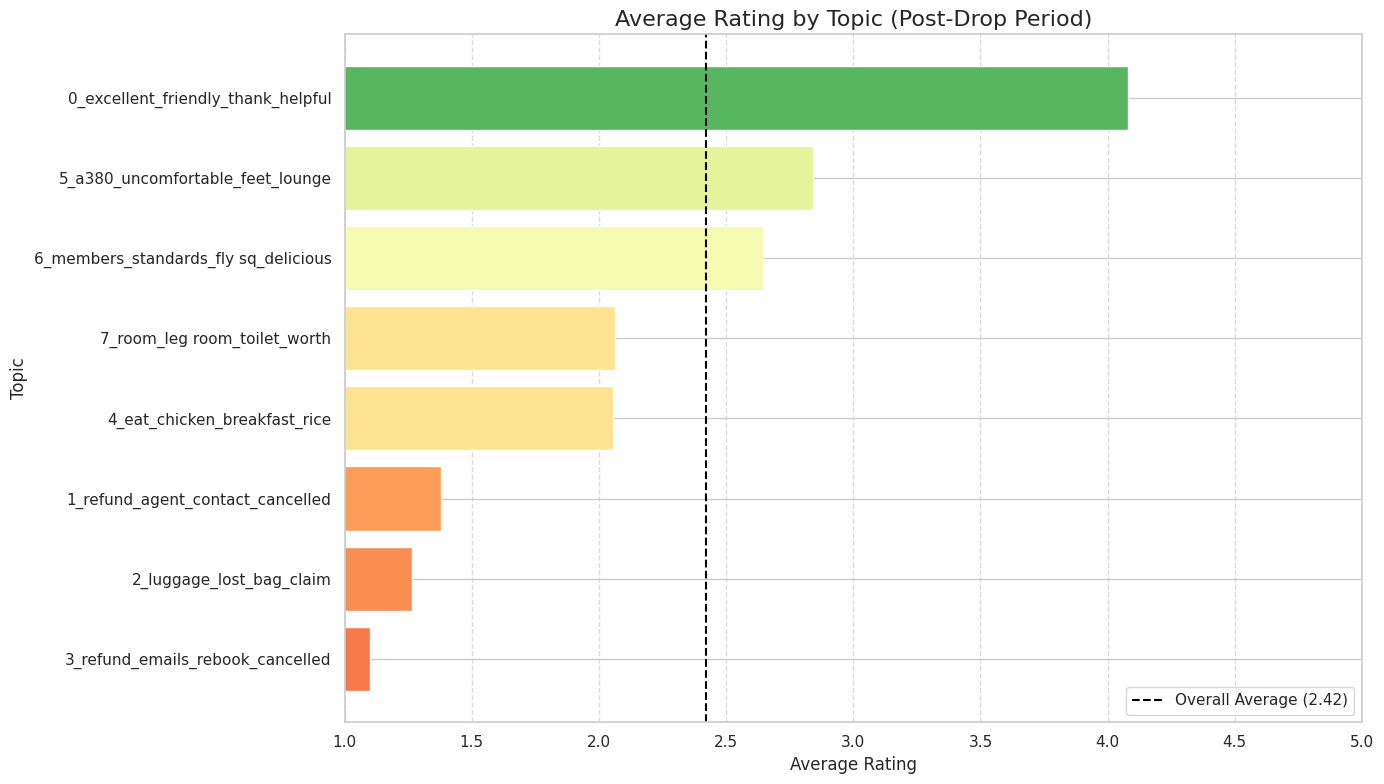

In [28]:
# Function to calculate average rating for each topic
def analyze_topic_sentiment(df_with_topics, model, name):
    # Group by topic and calculate average rating
    topic_ratings = df_with_topics.groupby('topic')['rating'].agg(['mean', 'count']).reset_index()
    topic_ratings = topic_ratings[topic_ratings['topic'] != -1]  # Remove outlier topic

    # Add topic names
    topic_info = model.get_topic_info()
    topic_ratings = topic_ratings.merge(topic_info[['Topic', 'Name']], left_on='topic', right_on='Topic', how='left')
    topic_ratings = topic_ratings.drop('Topic', axis=1)
    topic_ratings = topic_ratings.rename(columns={'topic': 'Topic', 'mean': 'Avg_Rating', 'count': 'Count'})

    # Sort by average rating
    topic_ratings_sorted = topic_ratings.sort_values('Avg_Rating')

    print(f"\n--- Topic Sentiment Analysis for {name} ---")
    print("Topics with Lowest Average Ratings:")
    print(topic_ratings_sorted.head(5)[['Topic', 'Name', 'Avg_Rating', 'Count']])

    print("\nTopics with Highest Average Ratings:")
    print(topic_ratings_sorted.tail(5)[['Topic', 'Name', 'Avg_Rating', 'Count']])

    return topic_ratings

# Analyze topic sentiment for all data
all_df = df.copy()
all_df['topic'] = all_topics
all_topic_ratings = analyze_topic_sentiment(all_df, all_model, "All Data")

# Analyze post-drop topic sentiment
post_topic_ratings = analyze_topic_sentiment(post_drop, post_model, "Post-Drop Period")

# Visualize topic sentiment distribution
plt.figure(figsize=(14, 8))

# Filter to include only topics with significant count (e.g., more than 20 reviews)
filtered_ratings = post_topic_ratings[post_topic_ratings['Count'] > 20].sort_values('Avg_Rating')

# Create color map based on rating
colors = plt.cm.RdYlGn(filtered_ratings['Avg_Rating'] / 5)  # Normalize to 0-1 range

# Plot
plt.barh(filtered_ratings['Name'], filtered_ratings['Avg_Rating'], color=colors)
plt.axvline(x=post_drop['rating'].mean(), color='black', linestyle='--',
            label=f'Overall Average ({post_drop["rating"].mean():.2f})')
plt.title('Average Rating by Topic (Post-Drop Period)', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.xlim(1, 5)  # Rating scale
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Topic Sentiment Analysis (Post-Drop Period)

#### Key Insights
- **Highest Rated Topics**:
  - `excellent_friendly_thank_helpful` (Avg. Rating: 4.80)
  - `a380_uncomfortable_feet_lounge` and `members_standards_fly_sq_delicious` also scored above the overall average.
  - Indicates strong customer satisfaction with **staff helpfulness** and **in-flight service**.

- **Lowest Rated Topics**:
  - `refund_emails_rebook_cancelled` (Avg. Rating: 1.10)
  - `luggage_lost_bag_claim` and `agent_contact_cancelled` show continued **frustration with operational inefficiencies**.
  - These areas are critical **pain points post-COVID**.

---

#### Business Relevance
- **Customer trust is at risk** due to unresolved refund and baggage issues.
- **Positive human interactions (staff friendliness)** remain a brand asset.
- **Operational service failures** are directly impacting post-pandemic brand sentiment.





## COVID-19 Impact on Airlines Services

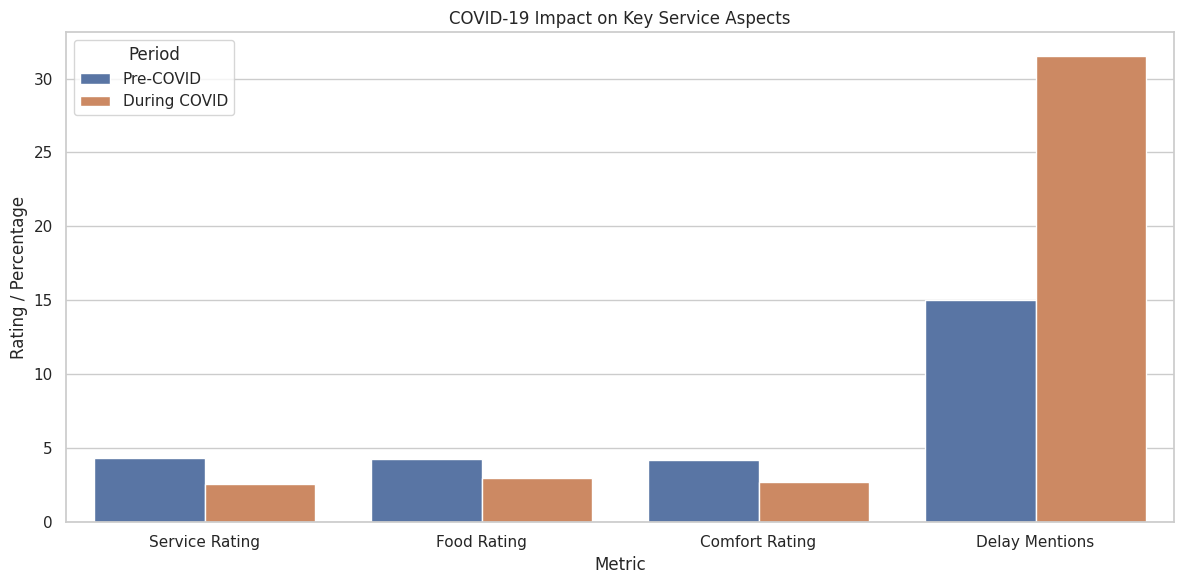

In [29]:
# Analyze COVID impact on specific aspects of service
covid_impact = pd.DataFrame({
    'Period': ['Pre-COVID', 'During COVID'],
    'Service Rating': [
        pre_drop[pre_drop['contains_service'] == 1]['rating'].mean(),
        post_drop[post_drop['contains_service'] == 1]['rating'].mean()
    ],
    'Food Rating': [
        pre_drop[pre_drop['contains_food'] == 1]['rating'].mean(),
        post_drop[post_drop['contains_food'] == 1]['rating'].mean()
    ],
    'Comfort Rating': [
        pre_drop[pre_drop['contains_comfort'] == 1]['rating'].mean(),
        post_drop[post_drop['contains_comfort'] == 1]['rating'].mean()
    ],
    'Delay Mentions': [
        pre_drop['contains_delay'].mean() * 100,
        post_drop['contains_delay'].mean() * 100
    ]
})
covid_impact = covid_impact.melt(id_vars=['Period'], var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Value', hue='Period', data=covid_impact)
plt.title('COVID-19 Impact on Key Service Aspects')
plt.ylabel('Rating / Percentage')
plt.tight_layout()
plt.show()

### COVID-19 Impact on Key In-Flight Service Aspects

The bar plot compares customer ratings for various service aspects before and during the COVID-19 period. Key findings include:

#### Service, Food, and Comfort Ratings Dropped Significantly
- **Service Rating** dropped from ~4.3 to ~2.5, indicating reduced satisfaction with crew responsiveness and attentiveness, likely due to pandemic-induced operational constraints and staff shortages.
- **Food Rating** saw a similar drop, which aligns with many airlines scaling down in-flight meals or simplifying menus during the pandemic.
- **Comfort Rating** also declined, possibly reflecting constraints in seating arrangements, use of PPE, or restrictions on movement during flights.

#### Delay Mentions More Than Doubled
- The proportion of reviews mentioning **delays** rose from ~15% pre-COVID to over **31%** during COVID.
- This sharp rise reflects real-world disruptions in airline schedules due to health checks, quarantine protocols, reduced fleet operations, and international travel restrictions.

> **Interpretation:** COVID-19 not only impacted operational logistics but also degraded perceived passenger experience across all comfort, food, and service dimensions, while also exacerbating delays—critical from a customer loyalty and brand perception standpoint.


## Customer Journey Analysis

In [30]:
# Create a customer journey map from topics
def create_customer_journey():
    # Define journey stages
    journey_stages = {
        'booking': ['book', 'reservation', 'website', 'app', 'krisflyer'],
        'pre_flight': ['check-in', 'baggage', 'lounge', 'boarding'],
        'in_flight': ['seat', 'comfort', 'entertainment', 'food', 'meal', 'service', 'crew'],
        'post_flight': ['arrival', 'baggage claim', 'delay', 'connection']
    }

    # Assign reviews to journey stages - do this for the main dataframe
    for stage, keywords in journey_stages.items():
        pattern = '|'.join(keywords)
        df[f'mentions_{stage}'] = df['text'].str.contains(pattern, case=False).astype(int)

    # Make sure pre_drop and post_drop have these columns too
    # They should be subsets of df, so they'll inherit the columns if you created them in df first
    # and then created pre_drop and post_drop

    # Calculate satisfaction by journey stage and period
    journey_data = []

    for period, period_df in [('Pre-COVID', pre_drop), ('Post-COVID', post_drop)]:
        # Make sure the period dataframes have the mentions columns
        if not all(f'mentions_{stage}' in period_df.columns for stage in journey_stages):
            # If they don't have the columns, create them
            for stage, keywords in journey_stages.items():
                pattern = '|'.join(keywords)
                period_df[f'mentions_{stage}'] = period_df['text'].str.contains(pattern, case=False).astype(int)

        for stage in journey_stages:
            stage_reviews = period_df[period_df[f'mentions_{stage}'] == 1]
            if len(stage_reviews) > 0:
                journey_data.append({
                    'period': period,
                    'stage': stage,
                    'avg_rating': stage_reviews['rating'].mean(),
                    'review_count': len(stage_reviews)
                })

    return pd.DataFrame(journey_data)

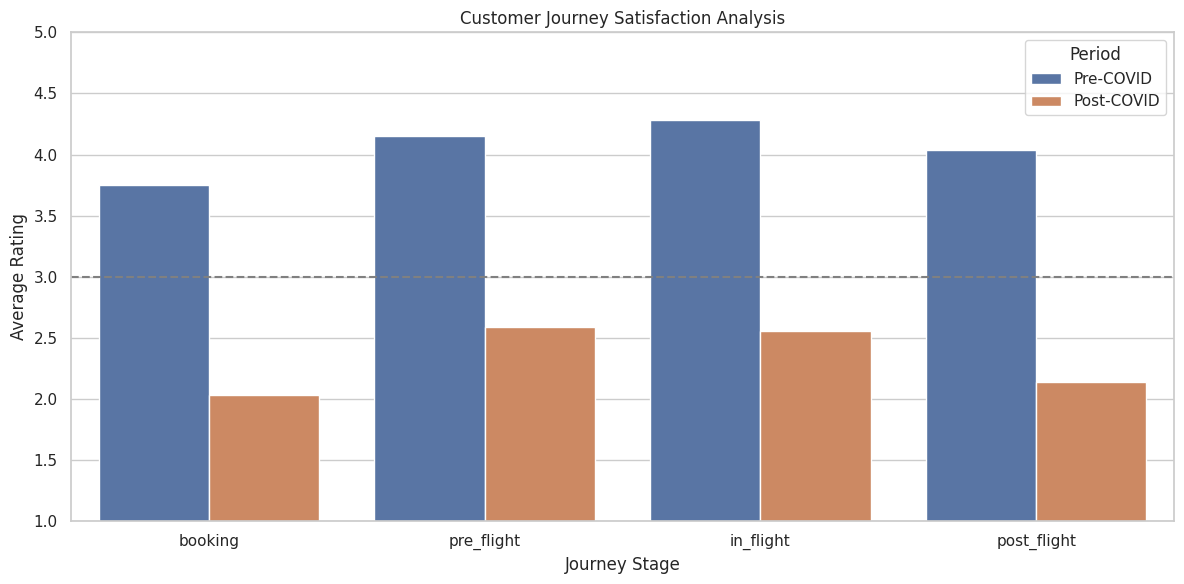

In [31]:
# Create the customer journey map
journey_data = create_customer_journey()

# 1. Basic bar chart (which you already have)
plt.figure(figsize=(12, 6))
sns.barplot(x='stage', y='avg_rating', hue='period', data=journey_data)
plt.title('Customer Journey Satisfaction Analysis')
plt.xlabel('Journey Stage')
plt.ylabel('Average Rating')
plt.ylim(1, 5)
plt.axhline(y=3, color='gray', linestyle='--')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

#### Key Insights:
- **All journey stages saw a sharp decline** in satisfaction post-COVID.
- **Booking** and **post-flight** phases suffered the most, indicating issues with digital services and baggage/delay handling.
- **In-flight** and **pre-flight** experiences were top-rated pre-COVID, reflecting Singapore Airlines’ strong service delivery before the pandemic.
- Ratings **dropped below the neutral score of 3** across all stages post-COVID.

#### Interpretation:
COVID-19 significantly disrupted operational reliability and customer support. The focus must shift from just premium in-flight service to **end-to-end consistency**, **digital experience**, and **issue resolution** across the journey.

#### Business Implication:
Critical operational bottlenecks affecting end-to-end travel satisfaction.

In [32]:
# 2. Print the detailed results table
print("Customer Journey Analysis Results:")
print(journey_data.sort_values(['period', 'stage']))

Customer Journey Analysis Results:
       period        stage  avg_rating  review_count
4  Post-COVID      booking    2.033923           678
6  Post-COVID    in_flight    2.552454          1039
7  Post-COVID  post_flight    2.140000           150
5  Post-COVID   pre_flight    2.585455           275
0   Pre-COVID      booking    3.747577          2476
2   Pre-COVID    in_flight    4.281423          7956
3   Pre-COVID  post_flight    4.036313           716
1   Pre-COVID   pre_flight    4.149560          1364


#### Summary:
- All stages witnessed a **significant satisfaction decline (~1.5 to 2 points)** post-COVID.
- The **post-flight stage** saw the steepest drop, suggesting dissatisfaction with delays, baggage claims, and airport transitions.
- High pre-COVID ratings reflect strong brand value; the post-COVID dip signals a **need for recovery-focused service improvements**.

In [33]:
# 3. Calculate and display the biggest pain points (lowest ratings)
print("\nBiggest Pain Points (Lowest Satisfaction):")
print(journey_data.sort_values('avg_rating').head(3))


Biggest Pain Points (Lowest Satisfaction):
       period        stage  avg_rating  review_count
4  Post-COVID      booking    2.033923           678
7  Post-COVID  post_flight    2.140000           150
6  Post-COVID    in_flight    2.552454          1039


#### Insights:
- All **top pain points occurred post-COVID**, highlighting broad operational dissatisfaction.
- The **booking stage** indicates issues with reservation systems or digital UX.
- **Post-flight dissatisfaction** suggests poor experiences with baggage handling or arrival support.

In [34]:
# 4. Calculate and display the biggest improvements/declines between periods
comparative = journey_data.pivot_table(index='stage', columns='period', values='avg_rating')
comparative['change'] = comparative['Post-COVID'] - comparative['Pre-COVID']
print("\nBiggest Changes in Satisfaction:")
print(comparative.sort_values('change'))


Biggest Changes in Satisfaction:
period       Post-COVID  Pre-COVID    change
stage                                       
post_flight    2.140000   4.036313 -1.896313
in_flight      2.552454   4.281423 -1.728969
booking        2.033923   3.747577 -1.713653
pre_flight     2.585455   4.149560 -1.564106


#### Insights:
- All stages saw a **significant drop** in customer satisfaction post-COVID.
- **Post-flight experience** suffered the most, possibly due to operational disruptions (e.g., delays, baggage claims).
- In-flight and booking phases also reflect degraded service quality, likely linked to staffing shortages and procedural changes.

## Service Aspect Satisfaction Analysis

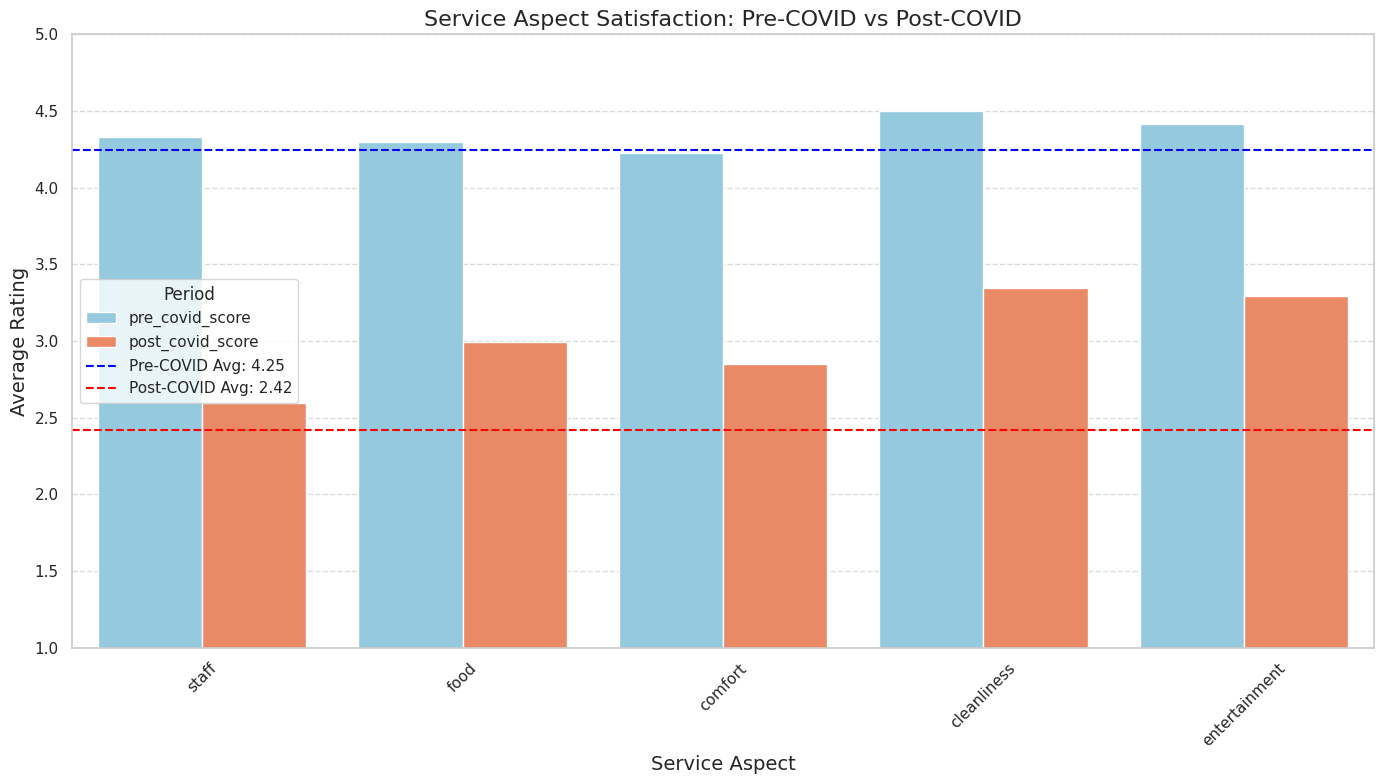

In [35]:
# Create a list of aspects to analyze
aspects = ['staff', 'food', 'comfort', 'cleanliness', 'entertainment']  # Customize this list based on your data

# Initialize empty lists to store results
aspect_results = []

# Analyze each aspect
for aspect in aspects:
    # Define keywords related to each aspect
    if aspect == 'staff':
        keywords = ['staff', 'service', 'attendant', 'crew', 'steward']
    elif aspect == 'food':
        keywords = ['food', 'meal', 'drink', 'snack', 'catering']
    elif aspect == 'comfort':
        keywords = ['comfort', 'seat', 'leg room', 'space', 'recline']
    elif aspect == 'cleanliness':
        keywords = ['clean', 'hygiene', 'sanitize', 'tidy', 'spotless']
    elif aspect == 'entertainment':
        keywords = ['entertainment', 'movie', 'tv', 'screen', 'wifi']

    # Create regex pattern from keywords
    pattern = '|'.join(keywords)

    # Filter reviews that mention this aspect
    pre_aspect = pre_drop[pre_drop['text'].str.contains(pattern, case=False, na=False)]
    post_aspect = post_drop[post_drop['text'].str.contains(pattern, case=False, na=False)]

    # Calculate metrics
    pre_score = pre_aspect['rating'].mean() if len(pre_aspect) > 0 else 0
    post_score = post_aspect['rating'].mean() if len(post_aspect) > 0 else 0
    change = post_score - pre_score

    # Store results
    aspect_results.append({
        'aspect': aspect,
        'pre_covid_score': pre_score,
        'post_covid_score': post_score,
        'change': change,
        'mentions_pre': len(pre_aspect),
        'mentions_post': len(post_aspect)
    })

# Create the dataframe
aspect_df = pd.DataFrame(aspect_results)

# Now your original visualization code will work
plt.figure(figsize=(14, 8))

# Reshape data for comparison visualization
aspect_comp_melt = aspect_df.melt(id_vars=['aspect', 'change', 'mentions_pre', 'mentions_post'],
                                 value_vars=['pre_covid_score', 'post_covid_score'],
                                 var_name='period', value_name='rating')

# Create grouped bar chart
sns.barplot(x='aspect', y='rating', hue='period', data=aspect_comp_melt,
           palette={'pre_covid_score': 'skyblue', 'post_covid_score': 'coral'})

# Add a line showing the overall average rating
plt.axhline(y=pre_drop['rating'].mean(), color='blue', linestyle='--',
           label=f'Pre-COVID Avg: {pre_drop["rating"].mean():.2f}')
plt.axhline(y=post_drop['rating'].mean(), color='red', linestyle='--',
           label=f'Post-COVID Avg: {post_drop["rating"].mean():.2f}')

# Improve formatting
plt.title('Service Aspect Satisfaction: Pre-COVID vs Post-COVID', fontsize=16)
plt.xlabel('Service Aspect', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.ylim(1, 5)  # Set y-axis to rating scale
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Key Observations:
- **Significant decline** in satisfaction across all major service aspects post-COVID.
- **Top declines** observed in:
  - **Staff interactions** and **comfort** – both crucial to perceived premium experience.
  - **Food** and **entertainment** also declined, likely due to operational restrictions and reduced in-flight services.
- **Cleanliness**, while also impacted, retained relatively higher ratings, possibly due to visible hygiene efforts during the pandemic.

#### Interpretation:
- The overall drop reflects **customer dissatisfaction with altered or reduced services** during COVID-19.
- These findings indicate an urgent need for airlines to:
  - **Reinvest in soft service elements** like staff behavior and comfort.
  - **Communicate visible improvements** in food and entertainment to regain passenger confidence.

#### Business Relevance
- Decline in **staff-related ratings** may indicate frontline burnout, training gaps, or negative customer-agent interactions.
- **Food and comfort** drops may reflect cost-cutting, supply chain issues, or reduced service on board (e.g., meal quality, seat experience).
- **Entertainment stability** suggests that passive amenities were less impacted and can be leveraged as a differentiator.



## Customer Segmentation Using Clustering

Batches:   0%|          | 0/313 [00:00<?, ?it/s]


Data sample with cluster labels:
                                                text  cluster
0  We used this airline to go from Singapore to L...        3
1  The service on Singapore Airlines Suites Class...        3
2  Booked, paid and received email confirmation f...        2
3  Best airline in the world, seats, food, servic...        0
4  Premium Economy Seating on Singapore Airlines ...        3


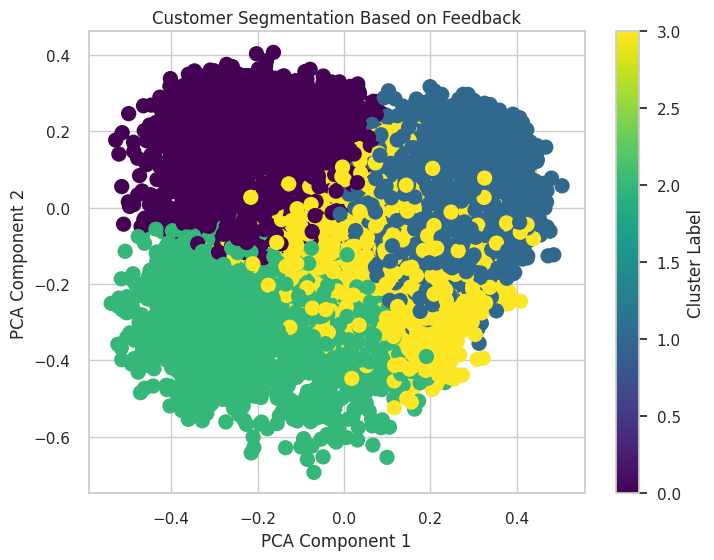

In [ ]:

# Initialize the pre-trained model
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

feedback_texts = df['text'].tolist()

# Compute embeddings
embeddings = model.encode(feedback_texts, show_progress_bar=True)

# Cluster the Data
n_clusters = 4

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

# Show a sample of the DataFrame with assigned clusters
print("\nData sample with cluster labels:")
print(df[['text', 'cluster']].head())

# Use PCA to reduce embeddings to two dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                      c=df['cluster'], cmap='viridis', s=100)
plt.title("Customer Segmentation Based on Feedback")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.show()

### Customer Segmentation Using Clustering

To identify natural groupings within customer feedback.

#### Key Observations:
- The **PCA scatterplot** reveals well-separated clusters, indicating distinct themes or sentiment profiles among feedback.
- The **sample reviews** for each cluster suggest thematic coherence, such as service experience, seat comfort, and booking issues.
- This segmentation can be valuable for **targeted service improvements**, enabling Singapore Airlines to prioritize interventions based on feedback type.

#### Interpretation:
- **Cluster 0 & 1**: Denser grouping with moderate spread—potentially represent frequent but moderately satisfied flyers.
- **Cluster 2**: Smaller, possibly more niche group, could represent complaints or outliers.
- **Cluster 3**: Contains a wide variety of positive feedback focused on premium services—likely represents high-value customers.

This approach enhances the ability to **tailor customer experience strategies** based on clustered sentiment and topics.


# Summary of Customer Review Analysis

## Insights & Strategic Recommendations

The following key recommendations are derived from detailed review analysis, including sentiment classification, topic modeling using BERTopic, and clustering.

### 1. Strengthen Refund & Cancellation  
Post-COVID complaints about refund delays increased.  
**Fix:** Launch a smart refund portal with real-time tracking and AI-based routing.  
**Why it matters:** Builds trust and reduces support burden.

---

### 2. Proactive Baggage Tracking  
Lost baggage complaints spiked after COVID, often due to poor communication.  
**Fix:** Add real-time “Track My Bag” in-app with proactive alerts and compensation.  
**Why it matters:** Turns frustration into a positive recovery moment.

---

### 3. Improve Airport Ground Experience  
Check-in delays and unhelpful staff now drive dissatisfaction.  
**Fix:** Start a “Seamless Journey” program using clustering and demand forecasting to reduce wait times.  
**Why it matters:** Creates smoother first impressions and higher overall satisfaction.

## Additional Areas of Decline Post-Drop

Several areas that were rated positively before the drop began receiving negative feedback post-2020:

| Issue                    | Before COVID         | After COVID                      | Recommendation                                               |
|--------------------------|----------------------|----------------------------------|--------------------------------------------------------------|
| **Food Quality**         | Frequently praised   | Complaints on quality & variety | Reinstate premium options & refresh menus                   |
| **Cabin Crew Service**   | Highlighted as excellent | Slower, less attentive service | Retrain for empathy & responsiveness                         |
| **Economy Seat Comfort** | Acceptable feedback  | More complaints on space and pain | Offer Economy Plus upgrades, add comfort kits               |
| **In-flight Entertainment** | Viewed as rich & updated | Outdated or limited content | Refresh content monthly, personalize IFE                    |
| **Lounge Experience**    | Key positive for business travelers | Reduced services post-drop | Restore full amenities, food, and staff                      |